In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib inline

from numba import jit

In [2]:
import metropolis 
# importing other files allows to access the functions,
# but doesn't execute the part of the if __name__ == "__main__": ...
# so here we don't get a plot.

1.5, -31.02, 0.215
1.6, -30.82, 0.277
1.7, -30.04, 0.402
1.8, -30.90, 0.398
1.9, -27.82, 0.489
2.0, -27.12, 0.619
2.1, -25.32, 0.65
2.2, -25.34, 0.772
2.3, -26.08, 0.767
2.4, -22.94, 0.812
2.5, -23.71, 0.751
2.6, -20.99, 0.798
2.7, -19.94, 0.767
2.8, -17.37, 0.697
2.9, -16.64, 0.634
3.0, -14.90, 0.588


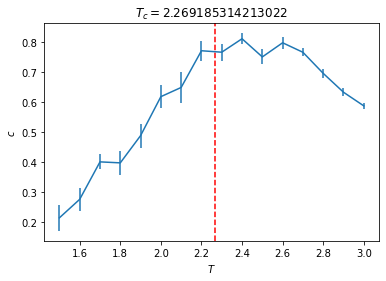

<Figure size 432x288 with 0 Axes>

In [3]:
# a)
%run metropolis.py  # this ipython magic also executes the if __name__ == "__main__": ... part

The script plots the specific heat for a range of temperatures around the critical point $T_c$. Note that the system is very small (4x4).

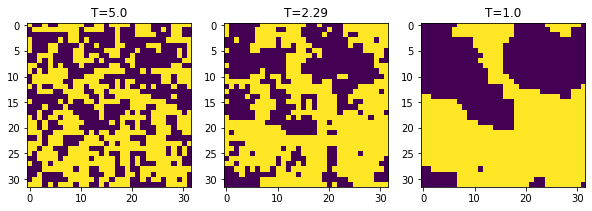

In [4]:
# b)
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
system = metropolis.prepare_system(32)
Ts =  [5., 2.29, 1.]
for i in range(3):
    T = Ts[i]
    metropolis.metropolis_loop(system, T, 10000, 1000, 10)  # get typical configurations
    axes[i].imshow(system, interpolation='none')   # plot it
    axes[i].set_title("T="+str(T))
plt.show()

## Interpretation
At high temperatures, the spins are unordered. At the critical temperature, the system is scale invariant and we see blocks of all sizes. In the ordere phases, the spins align and point in the same direction.

In [5]:
# c)
def run(T_range, L, N_sweeps, N_eq=None, N_bins=10, N_flips=10):
    """run a monte carlo simulation for given system size.
    
    Paramaters
    ----------
    T_range : temperatures
    L : system size
    N_sweeps : number of steps for the measurements
    N_eq : number of equilibration steps. Defaults to N_sweeps/10.
    N_bins : number of bins use for the error analysis
    N_flips : number of updates between measurements.
    
    Returns
    -------
    E_list : energies (and errors) at the different temperatures
    C_list : specific heat (and errors) at the different temperatures
    """
    if N_eq is None:
        N_eq = N_sweeps//10  # integer division
    C_list = []
    E_list = []
    system = metropolis.prepare_system(L)
    for T in T_range:
        C_list_bin = []
        E_list_bin = []
        M_list_bin = []
        M_abs_list_bin = []
        for k in range(N_bins):
            # run N_sweeps metropolis updates and store results the array Es
            Es = metropolis.metropolis_loop(system, T, N_sweeps, N_eq, N_flips)
            # evaluate observables
            mean_E = np.mean(Es)
            mean_E2 = np.mean(Es**2)            
            C_list_bin.append(1. / T**2. / L**2. * (mean_E2 - mean_E**2))
            E_list_bin.append(1. / L**2. * mean_E)
        # estimate error from binning analysis
        C_list.append([np.mean(C_list_bin), np.std(C_list_bin) / np.sqrt(N_bins)])
        E_list.append([np.mean(E_list_bin), np.std(E_list_bin) / np.sqrt(N_bins)])
    return np.array(E_list), np.array(C_list)

Note that we scale the number of sweeps with L**2 for better convergence
and that we keep the system state while cooling down
calculate L = 4
   took 0.2 seconds
calculate L = 8
   took 0.9 seconds
calculate L = 16
   took 3.5 seconds
calculate L = 32
   took 14.0 seconds


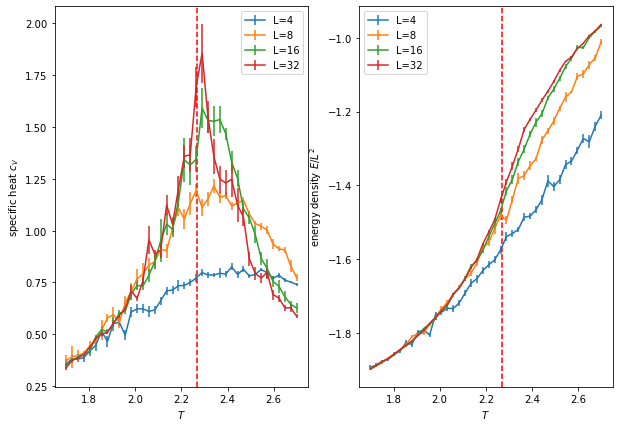

In [6]:
print("Note that we scale the number of sweeps with L**2 for better convergence")
print("and that we keep the system state while cooling down")

Ts = np.linspace(2.7, 1.7, 40)
fig, axes = plt.subplots(1, 2, figsize=(10, 7))
ax1, ax2 = axes
for L in [4, 8, 16, 32]:
    print("calculate L =", L, flush=True)
    t0 = time.time()
    E_list, C_list = run(Ts, L, N_sweeps=1000*L**2)
    # Plot the results
    ax1.errorbar(Ts, C_list[:, 0], C_list[:, 1], label='L={L:d}'.format(L=L))
    ax2.errorbar(Ts, E_list[:, 0], E_list[:, 1], label='L={L:d}'.format(L=L))
    print("   took {t:.1f} seconds".format(t=time.time()-t0))
Tc = 2. / np.log(1. + np.sqrt(2))
for ax in axes:
    ax.axvline(Tc, color='r', linestyle='--')
    ax.set_xlabel('$T$')
    ax.legend(loc='best')

ax1.set_ylabel('specific heat $c_V$')
ax2.set_ylabel('energy density $E/L^2$')
plt.show()

In [7]:
# d)
@jit(nopython=True)
def metropolis_loop(system, T, N_sweeps, N_eq, N_flips):
    """ Main loop doing the Metropolis algorithm."""
    M = np.sum(system)   # this is new
    E = metropolis.measure_energy(system)  # the "measure_energy" is defined in metropolis
    L = system.shape[0]
    E_list = []
    M_list = []  # this is new
    for step in range(N_sweeps + N_eq):
        i = np.random.randint(0, L)
        j = np.random.randint(0, L)

        dE = -2. * metropolis.energy(system, i, j, L)
        if dE <= 0.:
            system[i, j] *= -1
            E += dE
            M += 2*system[i,j]  # this is new
        elif np.exp(-1. / T * dE) > np.random.rand():
            system[i, j] *= -1
            E += dE
            M += 2*system[i,j]  # this is new

        if step >= N_eq and np.mod(step, N_flips) == 0:
            # measurement
            E_list.append(E)
            M_list.append(M)
    assert(M == np.sum(system)) # (error check, can be ommited)
    return np.array(E_list), np.array(M_list)

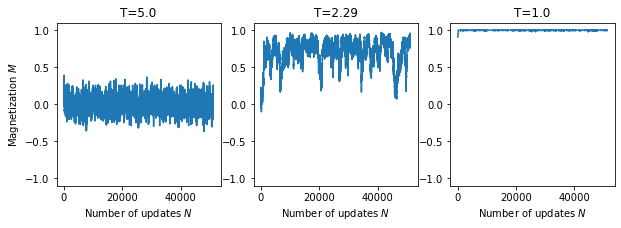

In [8]:
L = 16
system = metropolis.prepare_system(L)

fig, axes = plt.subplots(1, 3, figsize=(10, 3))
Ts =  [5., 2.29, 1.]
for i in range(3):
    T = Ts[i]
    Es, Ms = metropolis_loop(system, T, N_sweeps=2000*L**2, N_eq= N_sweeps//10, N_flips=10)
    axes[i].plot(Ms/L**2)
    axes[i].set_title("T="+str(T))
    axes[i].set_ylim(-1.1, 1.1)
    axes[i].set_xlabel(r'Number of updates $N$')

axes[0].set_ylabel(r'Magnetization $M$')
plt.show()

In [9]:
def run(T_range, L, N_sweeps, N_eq=None, N_bins=10, N_flips=10):
    """run a monte carlo simulation for given system size.
    
    Paramaters
    ----------
    T_range : temperatures
    L : system size
    N_sweeps : number of steps for the measurements
    N_eq : number of equilibration steps. Defaults to N_sweeps/10.
    N_bins : number of bins use for the error analysis
    N_flips : number of updates between measurements.
    
    Returns
    -------
    E_list : energies (and errors) at the different temperatures
    C_list : specific heat (and errors) at the different temperatures
    M_list : magnetization (and errors) at the different temperatures
    M_abs_list : absolute value of magnetization (and errors) at the different temperatures
    """
    if N_eq is None:
        N_eq = N_sweeps//10  # integer division
    C_list = []
    E_list = []
    M_list = []  # this is new
    M_abs_list = []  # this is new
    system = metropolis.prepare_system(L)
    for T in T_range:
        C_list_bin = []
        E_list_bin = []

        M_list_bin = []
        M_abs_list_bin = []
        for k in range(N_bins):
            Es, Ms = metropolis_loop(system, T, N_sweeps, N_eq, N_flips)  # the one defined above
            
            mean_E = np.mean(Es)
            mean_E2 = np.mean(Es**2)
            mean_M = np.mean(Ms)  # this is new
            mean_abs_M = np.mean(np.abs(Ms))  # this is new
            
            C_list_bin.append(1. / T**2. / L**2. * (mean_E2 - mean_E**2))
            E_list_bin.append(1. / L**2. * mean_E)
            M_list_bin.append(mean_M*1./L**2)  # this is new
            M_abs_list_bin.append(mean_abs_M*1./L**2)  # this is new
        C_list.append([np.mean(C_list_bin), np.std(C_list_bin) / np.sqrt(N_bins)])
        E_list.append([np.mean(E_list_bin), np.std(E_list_bin) / np.sqrt(N_bins)])
        M_list.append([np.mean(M_list_bin), np.std(M_list_bin) / np.sqrt(N_bins)])  # this is new
        M_abs_list.append([np.mean(M_abs_list_bin), np.std(M_abs_list_bin) / np.sqrt(N_bins)])  # this is new
    return np.array(E_list), np.array(C_list), np.array(M_list), np.array(M_abs_list)

calculate L = 4
   took 0.2 seconds
calculate L = 8
   took 0.9 seconds
calculate L = 16
   took 3.6 seconds
calculate L = 32
   took 14.1 seconds
calculate L = 64
   took 57.1 seconds


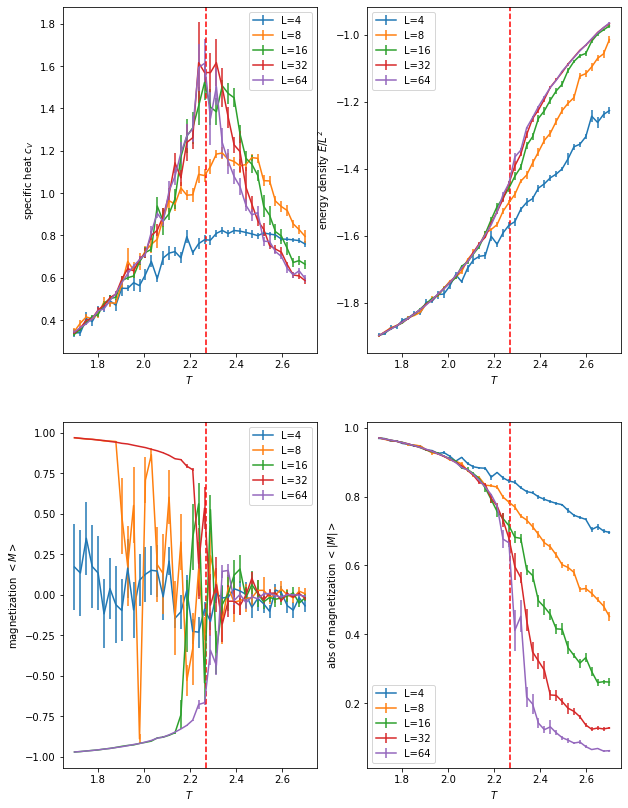

In [10]:
Ts = np.linspace(2.7, 1.7, 40)
fig, axes = plt.subplots(2, 2, figsize=(10, 14))
(ax1, ax2), (ax3, ax4) = axes
for L in [4, 8, 16, 32, 64]:
    print("calculate L =", L, flush=True)
    t0 = time.time()
    E_list, C_list, M_list, M_abs_list = run(Ts, L, N_sweeps=1000*L**2)
    # Plot the results
    ax1.errorbar(Ts, C_list[:, 0], C_list[:, 1], label='L={L:d}'.format(L=L))
    ax2.errorbar(Ts, E_list[:, 0], E_list[:, 1], label='L={L:d}'.format(L=L))
    ax3.errorbar(Ts, M_list[:, 0], M_list[:, 1], label='L={L:d}'.format(L=L))
    ax4.errorbar(Ts, M_abs_list[:, 0], M_abs_list[:, 1], label='L={L:d}'.format(L=L))
    print("   took {t:.1f} seconds".format(t=time.time()-t0))
Tc = 2. / np.log(1. + np.sqrt(2))
for ax in axes.flatten():
    ax.axvline(Tc, color='r', linestyle='--')
    ax.set_xlabel('$T$')
    ax.legend(loc='best')

ax1.set_ylabel('specific heat $c_V$')
ax2.set_ylabel('energy density $E/L^2$')
ax3.set_ylabel('magnetization $<M>$')
ax4.set_ylabel('abs of magnetization $<|M|>$')
plt.show()

## Comments

- The specific heat (and also the magnetic susceptibiliy, which we didn't calculate) has a peak getting sharper with increasing L
- Due to symmetry (flipping all spins), the exat value for < M > should be 0 at all temperatures!
  For low temperatures, the spins align ferromagnetically, and the probability to flip all of them goes to zero.
  Our updates are thus not ergodic anymore!
- The auto-correlation time diverges around the critical point; the error estimates are actually too small (fluctuations    are larger than the error bars!). This is known as "critical slowing down".

In [11]:
# e)

@jit(nopython=True)
def metropolis_loop_h(system, T, N_sweeps, N_eq, N_flips, h):
    """ Main loop doing the Metropolis algorithm."""
    M = np.sum(system)   # this is new
    E = metropolis.measure_energy(system) - h * M # include the h here
    L = system.shape[0]
    E_list = []
    M_list = []
    for step in range(N_sweeps + N_eq):
        i = np.random.randint(0, L)
        j = np.random.randint(0, L)
        dE = -2. * metropolis.energy(system, i, j, L)  + h * 2* system[i, j]  # and another place where h is needed
        if dE <= 0.:
            system[i, j] *= -1
            E += dE
            M += 2*system[i,j]
        elif np.exp(-1. / T * dE) > np.random.rand():
            system[i, j] *= -1
            E += dE
            M += 2*system[i,j]
        if step >= N_eq and np.mod(step, N_flips) == 0:
            # measurement
            E_list.append(E)
            M_list.append(M)
    assert(M == np.sum(system))
    return np.array(E_list), np.array(M_list)


def run_h(T_range, L, N_sweeps, N_eq=None, N_bins=10, N_flips=10, h=0.):
    """run a monte carlo simulation for given system size
    
    Paramaters
    ----------
    T_range : temperatures
    L : system size
    N_sweeps : number of steps for the measurements
    N_eq : number of equilibration steps. Defaults to N_sweeps/10.
    N_bins : number of bins use for the error analysis
    N_flips : number of updates between measurements.
    h : magnetic field
    
    Returns
    -------
    E_list : energies (and errors) at the different temperatures
    C_list : specific heat (and errors) at the different temperatures
    M_list : magnetization (and errors) at the different temperatures
    M_abs_list : absolute value of magnetization (and errors) at the different temperatures
    """
    if N_eq is None:
        N_eq = N_sweeps//10  # integer division
    C_list = []
    E_list = []
    M_list = []  # this is new
    M_abs_list = []  # this is new
    system = metropolis.prepare_system(L)
    for T in T_range:
        C_list_bin = []
        E_list_bin = []

        M_list_bin = []
        M_abs_list_bin = []
        for k in range(N_bins):
            Es, Ms = metropolis_loop_h(system, T, N_sweeps, N_eq, N_flips, h)  # the one defined above

            mean_E = np.mean(Es)
            mean_E2 = np.mean(Es**2)
            mean_M = np.mean(Ms)
            mean_abs_M = np.mean(np.abs(Ms))
            
            C_list_bin.append(1. / T**2. / L**2. * (mean_E2 - mean_E**2))
            E_list_bin.append(1. / L**2. * mean_E)
            M_list_bin.append(mean_M*1./L**2)
            M_abs_list_bin.append(mean_abs_M*1./L**2)
        C_list.append([np.mean(C_list_bin), np.std(C_list_bin) / np.sqrt(N_bins)])
        E_list.append([np.mean(E_list_bin), np.std(E_list_bin) / np.sqrt(N_bins)])
        M_list.append([np.mean(M_list_bin), np.std(M_list_bin) / np.sqrt(N_bins)])  # this is new
        M_abs_list.append([np.mean(M_abs_list_bin), np.std(M_abs_list_bin) / np.sqrt(N_bins)])  # this is new
    return np.array(E_list), np.array(C_list), np.array(M_list), np.array(M_abs_list)

calculate L = 4
   took 0.5 seconds
calculate L = 8
   took 1.0 seconds
calculate L = 16
   took 3.9 seconds


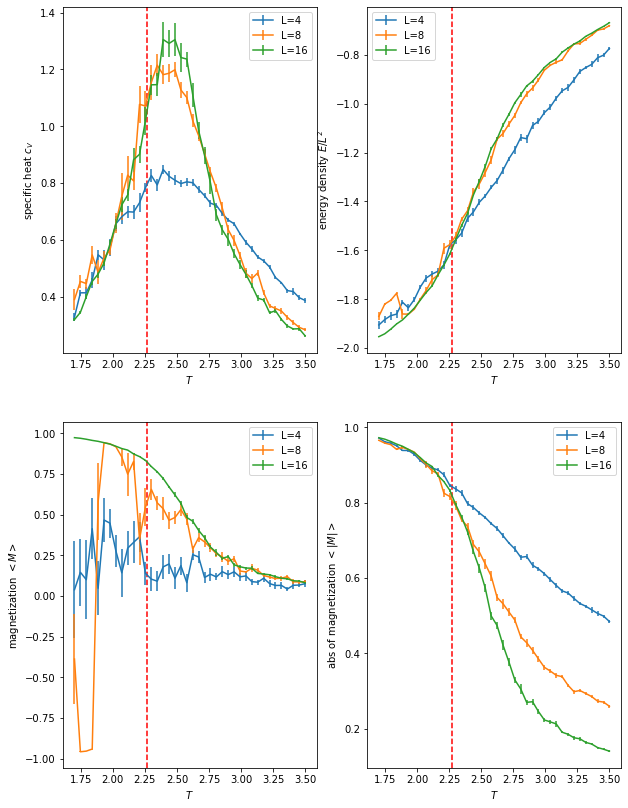

In [12]:
# and make the plots again for non-zero h
h = 0.05

Ts = np.linspace(3.5, 1.7, 40)
fig, axes = plt.subplots(2, 2, figsize=(10, 14))
(ax1, ax2), (ax3, ax4) = axes
for L in [4, 8, 16]:
    print("calculate L =", L, flush=True)
    t0 = time.time()
    E_list, C_list, M_list, M_abs_list = run_h(Ts, L, N_sweeps=1000*L**2, h=h)
    # Plot the results
    ax1.errorbar(Ts, C_list[:, 0], C_list[:, 1], label='L={L:d}'.format(L=L))
    ax2.errorbar(Ts, E_list[:, 0], E_list[:, 1], label='L={L:d}'.format(L=L))
    ax3.errorbar(Ts, M_list[:, 0], M_list[:, 1], label='L={L:d}'.format(L=L))
    ax4.errorbar(Ts, M_abs_list[:, 0], M_abs_list[:, 1], label='L={L:d}'.format(L=L))
    print("   took {t:.1f} seconds".format(t=time.time()-t0))
Tc = 2. / np.log(1. + np.sqrt(2))
for ax in axes.flatten():
    ax.axvline(Tc, color='r', linestyle='--')
    ax.set_xlabel('$T$')
    ax.legend(loc='best')

ax1.set_ylabel('specific heat $c_V$')
ax2.set_ylabel('energy density $E/L^2$')
ax3.set_ylabel('magnetization $<M>$')
ax4.set_ylabel('abs of magnetization $<|M|>$')
plt.show()